In [1]:
# Check version of R
version

               _                           
platform       aarch64-apple-darwin20      
arch           aarch64                     
os             darwin20                    
system         aarch64, darwin20           
status                                     
major          4                           
minor          2.0                         
year           2022                        
month          04                          
day            22                          
svn rev        82229                       
language       R                           
version.string R version 4.2.0 (2022-04-22)
nickname       Vigorous Calisthenics       

In [3]:
library(tidyverse)
library(data.table)
library(broom)
library(dtplyr)
library(lme4) #for lmer & glmer models
library(lmerTest)
library(psych)
library(corrplot)
library(sjPlot) #for plotting lmer and glmer mods

## SONA IV

Created an updated version of the measure (June 2022)

In [4]:
dataFileNumeric = "../../3_1_1_raw_data/SONA/IB_numeric_SONA4_JuneVersion_03082022.csv"

In [5]:
# Numeric
df <- as.data.table(read_csv(dataFileNumeric, show_col_types = FALSE))
df = df[Status=='0'] # select non-preview, non-metadata rows

# Clean Data

## Description

We removed all subjects who didn't agree to both of the questions on the debrief:

> 1. I consent for my data to be analyzed by the research team
> 2. I consent for my anonymized data to be shared on data sharing platforms

We also removed those subjects who failed the attention check. The full questionnaire had a single attention check inserted into the `Secular Work Ethic` scale in the second to last position.

And we removed duplicate subjects...

---

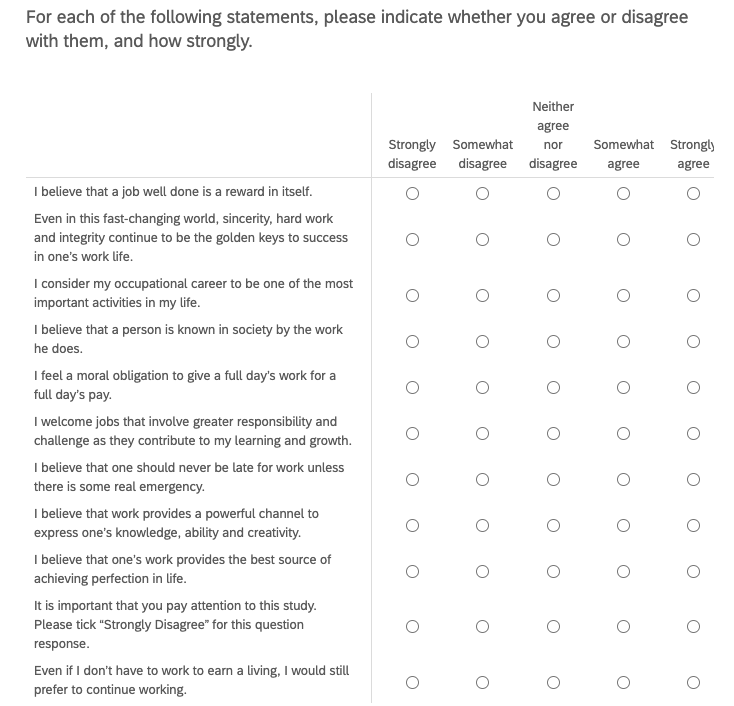

## Cleaning function

In [6]:
clean_data = function(df, numeric, detail, retest=FALSE){
    if(numeric){
        #### Remove me 
        df = df[df$id!='829',]

        #### Check for survey completion
        x = length(df$id) # length pre-cleaning step
        df = df[df$Progress=='100']
        if(detail){
            print(paste0('Removed ', x-length(df$id), ' subjects who did not complete survey... ', length(df$id), ' subjects remaining.'))
        }
        
        ### Check for duplicate subject ids
        if(detail){
            print(paste0('There were ', sum(duplicated(df$id)), ' duplicated subjects:'))
            print(df$id[duplicated(df$id)])
        }
        # remove dupes
        x = length(df$id) # length pre-cleaning step
        df = df[!duplicated(df$id),]
        if(detail){
            print(paste0('Removed ', x-length(df$id), ' instances where subjects completed the survey more than once... ',
                     length(df$id), ' subjects remaining.'))
        }
        
        #### Remove subjects who don't agree to debrief
        x = length(df$id) # length pre-cleaning step
        df = df[debrief_form_1 == 1 & debrief_form_2 == 1]
        if(detail){
            print(paste0('Removed ', x-length(df$id), ' subjects who did not agree to debrief... ', length(df$id), ' subjects remaining.'))
        }
        
        #### Attention check
        if (retest==FALSE){ # test retest did not have attention check
            if("attention_check" %in% colnames(df)){ # column changed naming
                # attention check requires answer of 'Strongly disagree' 
                x = length(df$id) # length pre-cleaning step
                df = df[df$attention_check==1]
                if(detail){
                    print(paste0('Removed ', x-length(df$id), ' subjects who failed attention check... ', length(df$id), ' subjects remaining.'))
                }
            }
            if("bscs_attention" %in% colnames(df)){ # column changed naming
                # attention check requires answer of 'Strongly disagree' 
                x = length(df$id) # length pre-cleaning step
                df = df[df$bscs_attention==1]
                if(detail){
                    print(paste0('Removed ', x-length(df$id), ' subjects who failed attention check... ', length(df$id), ' subjects remaining.'))
                }
            }
            else{
                print("Warning! No attention check in data...")
            }
        }
        print(paste0('Number of cleaned subjects: ', length(df$id)))
    }
    
    # NON NUMERIC
    else{
        #### Remove me (for some reason I am in the initial dfs...)
        df = df[df$id!='829',]

        #### Check for survey completion
        x = length(df$id) # length pre-cleaning step
        df = df[df$Progress=='100']
        if(detail){
            print(paste0('Removed ', x-length(df$id), ' subjects who did not complete survey... ', length(df$id), ' subjects remaining.'))
        }
        
        ### Check for duplicate subject ids
        if(detail){
            print(paste0('There were ', sum(duplicated(df$id)), ' duplicated subjects:'))
            print(df$id[duplicated(df$id)])
        }
        # remove dupes
        x = length(df$id) # length pre-cleaning step
        df = df[!duplicated(df$id),]
        if(detail){
            print(paste0('Removed ', x-length(df$id), ' instances where subjects completed the survey more than once... ',
                     length(df$id), ' subjects remaining.'))
        }
        
        #### Remove subjects who don't agree to debrief
        x = length(df$id) # length pre-cleaning step
        df = df[debrief_form_1 == 'Yes' & debrief_form_2 == 'Yes']
        if(detail){
            print(paste0('Removed ', x-length(df$id), ' subjects who did not agree to debrief... ', length(df$id), ' subjects remaining.'))
        }

        #### Attention check 
        if (retest==FALSE){ # test retest did not have attention check
            if("attention_check" %in% colnames(df)){ # column changed naming
            # attention check requires answer of 'Strongly disagree' 
                x = length(df$id) # length pre-cleaning step
                df = df[df$attention_check=='Strongly disagree']
                if(detail){
                    print(paste0('Removed ', x-length(df$id), ' subjects who failed attention check... ', length(df$id), ' subjects remaining.'))
                }
            }
            if("bscs_attention" %in% colnames(df)){ # column changed naming
                # attention check requires answer of 'Strongly disagree' 
                x = length(df$id) # length pre-cleaning step
                df = df[df$bscs_attention=='Strongly disagree']
                if(detail){
                    print(paste0('Removed ', x-length(df$id), ' subjects who failed attention check... ', length(df$id), ' subjects remaining.'))
                }
            }
            else{
                print("Warning! No attention check in data...")
            }
        }
        
        print(paste0('Number of cleaned subjects: ', length(df$id)))
    }
    return(df)
}

In [7]:
# SONA 4 (June 2022 edition)
# numeric
df = clean_data(df, numeric = TRUE, detail = TRUE)

[1] "Removed 17 subjects who did not complete survey... 73 subjects remaining."
[1] "There were 0 duplicated subjects:"
character(0)
[1] "Removed 0 instances where subjects completed the survey more than once... 73 subjects remaining."
[1] "Removed 2 subjects who did not agree to debrief... 71 subjects remaining."
[1] "Removed 16 subjects who failed attention check... 55 subjects remaining."
[1] "Number of cleaned subjects: 55"


## Rename Domains

### Description

**NOTE:** 
- Added `Personal Values` and `Other` to the **June 2022** version of the measure
- Removed `Cleaning` as it correlated very highly with `Housework` and added `Hobby` not including those already listed as another category

### Rename Function

In [8]:
# number of domains
domain_num = df %>% select(contains('ib_domain_goal')) %>% as_tibble() %>% ncol()

In [9]:
rename_domains = function(df, domain_num){
    # list of domain categories
    ib_domain_cats = c('ambition', 'effort', 'external',
                       'goal', 'import', 'internal',
                       'rank', 'satis', 'source', 'specific',
                       'success', 'time'
                      )

    domain_names = c("Diet",
                     "Exercise",
                     "MentalPersonal_Health",
                     "Medical_Health",
                     "Sleep",
                     "Alcohol_drug",
                     "Online",
                     "Phone",
                     "Video games",
                     "Reading_leisure",
                     "SocialMedia",
                     "Sports_playing",
                     "TV_Streaming",
                     "Family",
                     "Friends",
                     "Partner",
                     "Social_life",
                     "Hobby",
                     "Housework",
                     "Cooking",
                     "Work_School",
                     "Environment",
                     "Culture",
                     "Learning",
                     "Self-Improvement",
                     "Volunteering",
                     "Community involvement",
                     "Admin",
                     "Future_Planning",
                     "Finances",
                     "Time_Management",
                     "Punctuality",
                     "Personal_Values",
                     "Other"
                    )

    for (i in 1:length(ib_domain_cats)) {
        # make a list of the existing names for each cateogry
        old_names = df %>%
            select(starts_with('ib_domain')) %>%
            select(contains(ib_domain_cats[i], ignore.case = FALSE)) %>%
            as_tibble() %>%
            names()

        # make a list of names with category and domain
        new_names = rep('ib_domain_', domain_num)
        new_names = paste0(new_names,ib_domain_cats[i], '_', domain_names)

        # replace existing names with new names
        df = df %>%
            rename_at(vars(all_of(old_names)), ~ new_names) %>%
            as_tibble()
    }

    return(df)
}

### Rename Domains for each DF

In [10]:
# sona IV
df = rename_domains(df, domain_num)

# Data Overview

In [11]:
#how many people chose each domain as a goal?

df %>% 
    select(contains('ib_domain_goal')) %>% 
    as_tibble() %>%
    sapply(as.numeric) %>%
    rowSums()

[1] 24 23 30 23 23 27 14 12 14 23 29 21 26 21 22 22 15 15 32 19 13  9 18 18 23
[26] 20  4 26 26 18 21 12 22 20  5 19 18  2 29 18 24 18  7 29 26 18 19 20 12 26
[51] 32 15 11 30 20

In [12]:
# which domains were chosen?
df %>% 
    select(contains('ib_domain_goal')) %>% 
    as_tibble() %>%
    sapply(as.numeric) %>%
    colSums() %>%
    sort()

ib_domain_goal_Alcohol_drug ib_domain_goal_Community involvement 
                                  12                                   18 
                ib_domain_goal_Admin                 ib_domain_goal_Other 
                                  18                                   19 
          ib_domain_goal_Environment           ib_domain_goal_Video games 
                                  20                                   21 
         ib_domain_goal_TV_Streaming               ib_domain_goal_Culture 
                                  21                                   21 
         ib_domain_goal_Volunteering                 ib_domain_goal_Phone 
                                  21                                   22 
              ib_domain_goal_Partner                ib_domain_goal_Online 
                                  23                                   27 
          ib_domain_goal_SocialMedia       ib_domain_goal_Reading_leisure 
                                  27                                   29 
       ib_domain_goal_Sports_playing              ib_domain_goal_Learning 
                                  30                                   31 
              ib_domain_goal_Cooking        ib_domain_goal_Medical_Health 
                                  32                                   34 
            ib_domain_goal_Housework                ib_domain_goal_Family 
                                  35                                   36 
          ib_domain_goal_Social_life           ib_domain_goal_Punctuality 
                                  37                                   37 
                 ib_domain_goal_Diet                 ib_domain_goal_Hobby 
                                  38                                   38 
              ib_domain_goal_Friends ib_domain_goal_MentalPersonal_Health 
                                  40                                   41 
                ib_domain_goal_Sleep              ib_domain_goal_Finances 
                                  42                                   42 
      ib_domain_goal_Time_Management              ib_domain_goal_Exercise 
                                  42                                   43 
      ib_domain_goal_Future_Planning       ib_domain_goal_Personal_Values 
                                  43                                   43 
     ib_domain_goal_Self-Improvement           ib_domain_goal_Work_School 
                                  49                                   51

In [13]:
df$duration = as.numeric(df$`Duration (in seconds)`)/60

In [17]:
sort(df$duration)

[1]   28.21667   34.56667   34.73333   36.95000   44.45000   46.65000
 [7]   49.01667   49.11667   50.05000   53.16667   54.91667   57.56667
[13]   59.48333   61.28333   61.35000   62.46667   62.55000   68.21667
[19]   71.16667   71.31667   74.35000   78.25000   80.88333   82.91667
[25]   83.53333   84.88333   85.55000   89.65000   91.83333   97.96667
[31]  104.08333  107.25000  107.31667  123.81667  124.45000  127.38333
[37]  130.35000  132.21667  138.63333  143.23333  149.45000  161.88333
[43]  164.53333  165.71667  169.03333  170.83333  188.03333  244.26667
[49]  251.86667  461.83333  466.55000  780.81667  787.16667  870.51667
[55] 1032.56667

In [19]:
clean_sona4 = df %>%
    filter(duration>44) %>%
    as_tibble()

# Between Domain Conflict

In [1]:
domain_names = c("Diet",
                 "Exercise",
                 "MentalPersonal_Health",
                 "Medical_Health",
                 "Sleep",
                 "Alcohol_drug",
                 "Online",
                 "Phone",
                 "Video games",
                 "Reading_leisure",
                 "SocialMedia",
                 "Sports_playing",
                 "TV_Streaming",
                 "Family",
                 "Friends",
                 "Partner",
                 "Social_life",
                 "Hobby",
                 "Housework",
                 "Cooking",
                 "Work_School",
                 "Environment",
                 "Culture",
                 "Learning",
                 "Self-Improvement",
                 "Volunteering",
                 "Community involvement",
                 "Admin",
                 "Future_Planning",
                 "Finances",
                 "Time_Management",
                 "Punctuality",
                 "Personal_Values",
                 "Other"
                )

In [21]:
# create list of all pairwise interactions
all_interactions = NA
counter = 1

for (domain1 in domain_names){
    for (domain2 in domain_names){
        interaction = paste0(domain1, '_interact_', domain2)
        all_interactions[counter] = interaction
        counter=counter+1
    }
}

In [22]:
# select interaction columns from df
interaction_df = clean_sona4 %>%
    select(contains('goal_interact')) %>%
    sapply(as.numeric) %>%
    as_tibble()

In [23]:
# rename columns
names(interaction_df) = all_interactions

**Domain Interaction Coding**

- 1 = very positive
- 4 = neutral
- 7 = very negative

In [24]:
# get count (non NAs)
df_int_n = as.data.frame.list(colSums(!is.na(interaction_df)))
# convert to df
df_int_n_long = gather(df_int_n, interaction, count, Diet_interact_Diet:Other_interact_Other)

# get mean pairwise domain conflict
df_int_val = as.data.frame.list(colMeans(interaction_df, na.rm=T))
# convert to df
df_int_val_long = gather(df_int_val, interaction, value, Diet_interact_Diet:Other_interact_Other)

# combine into single df
df_long = df_int_val_long
df_long$n = df_int_n_long$count
# reorder
df_long = df_long[order(-df_long$value),]

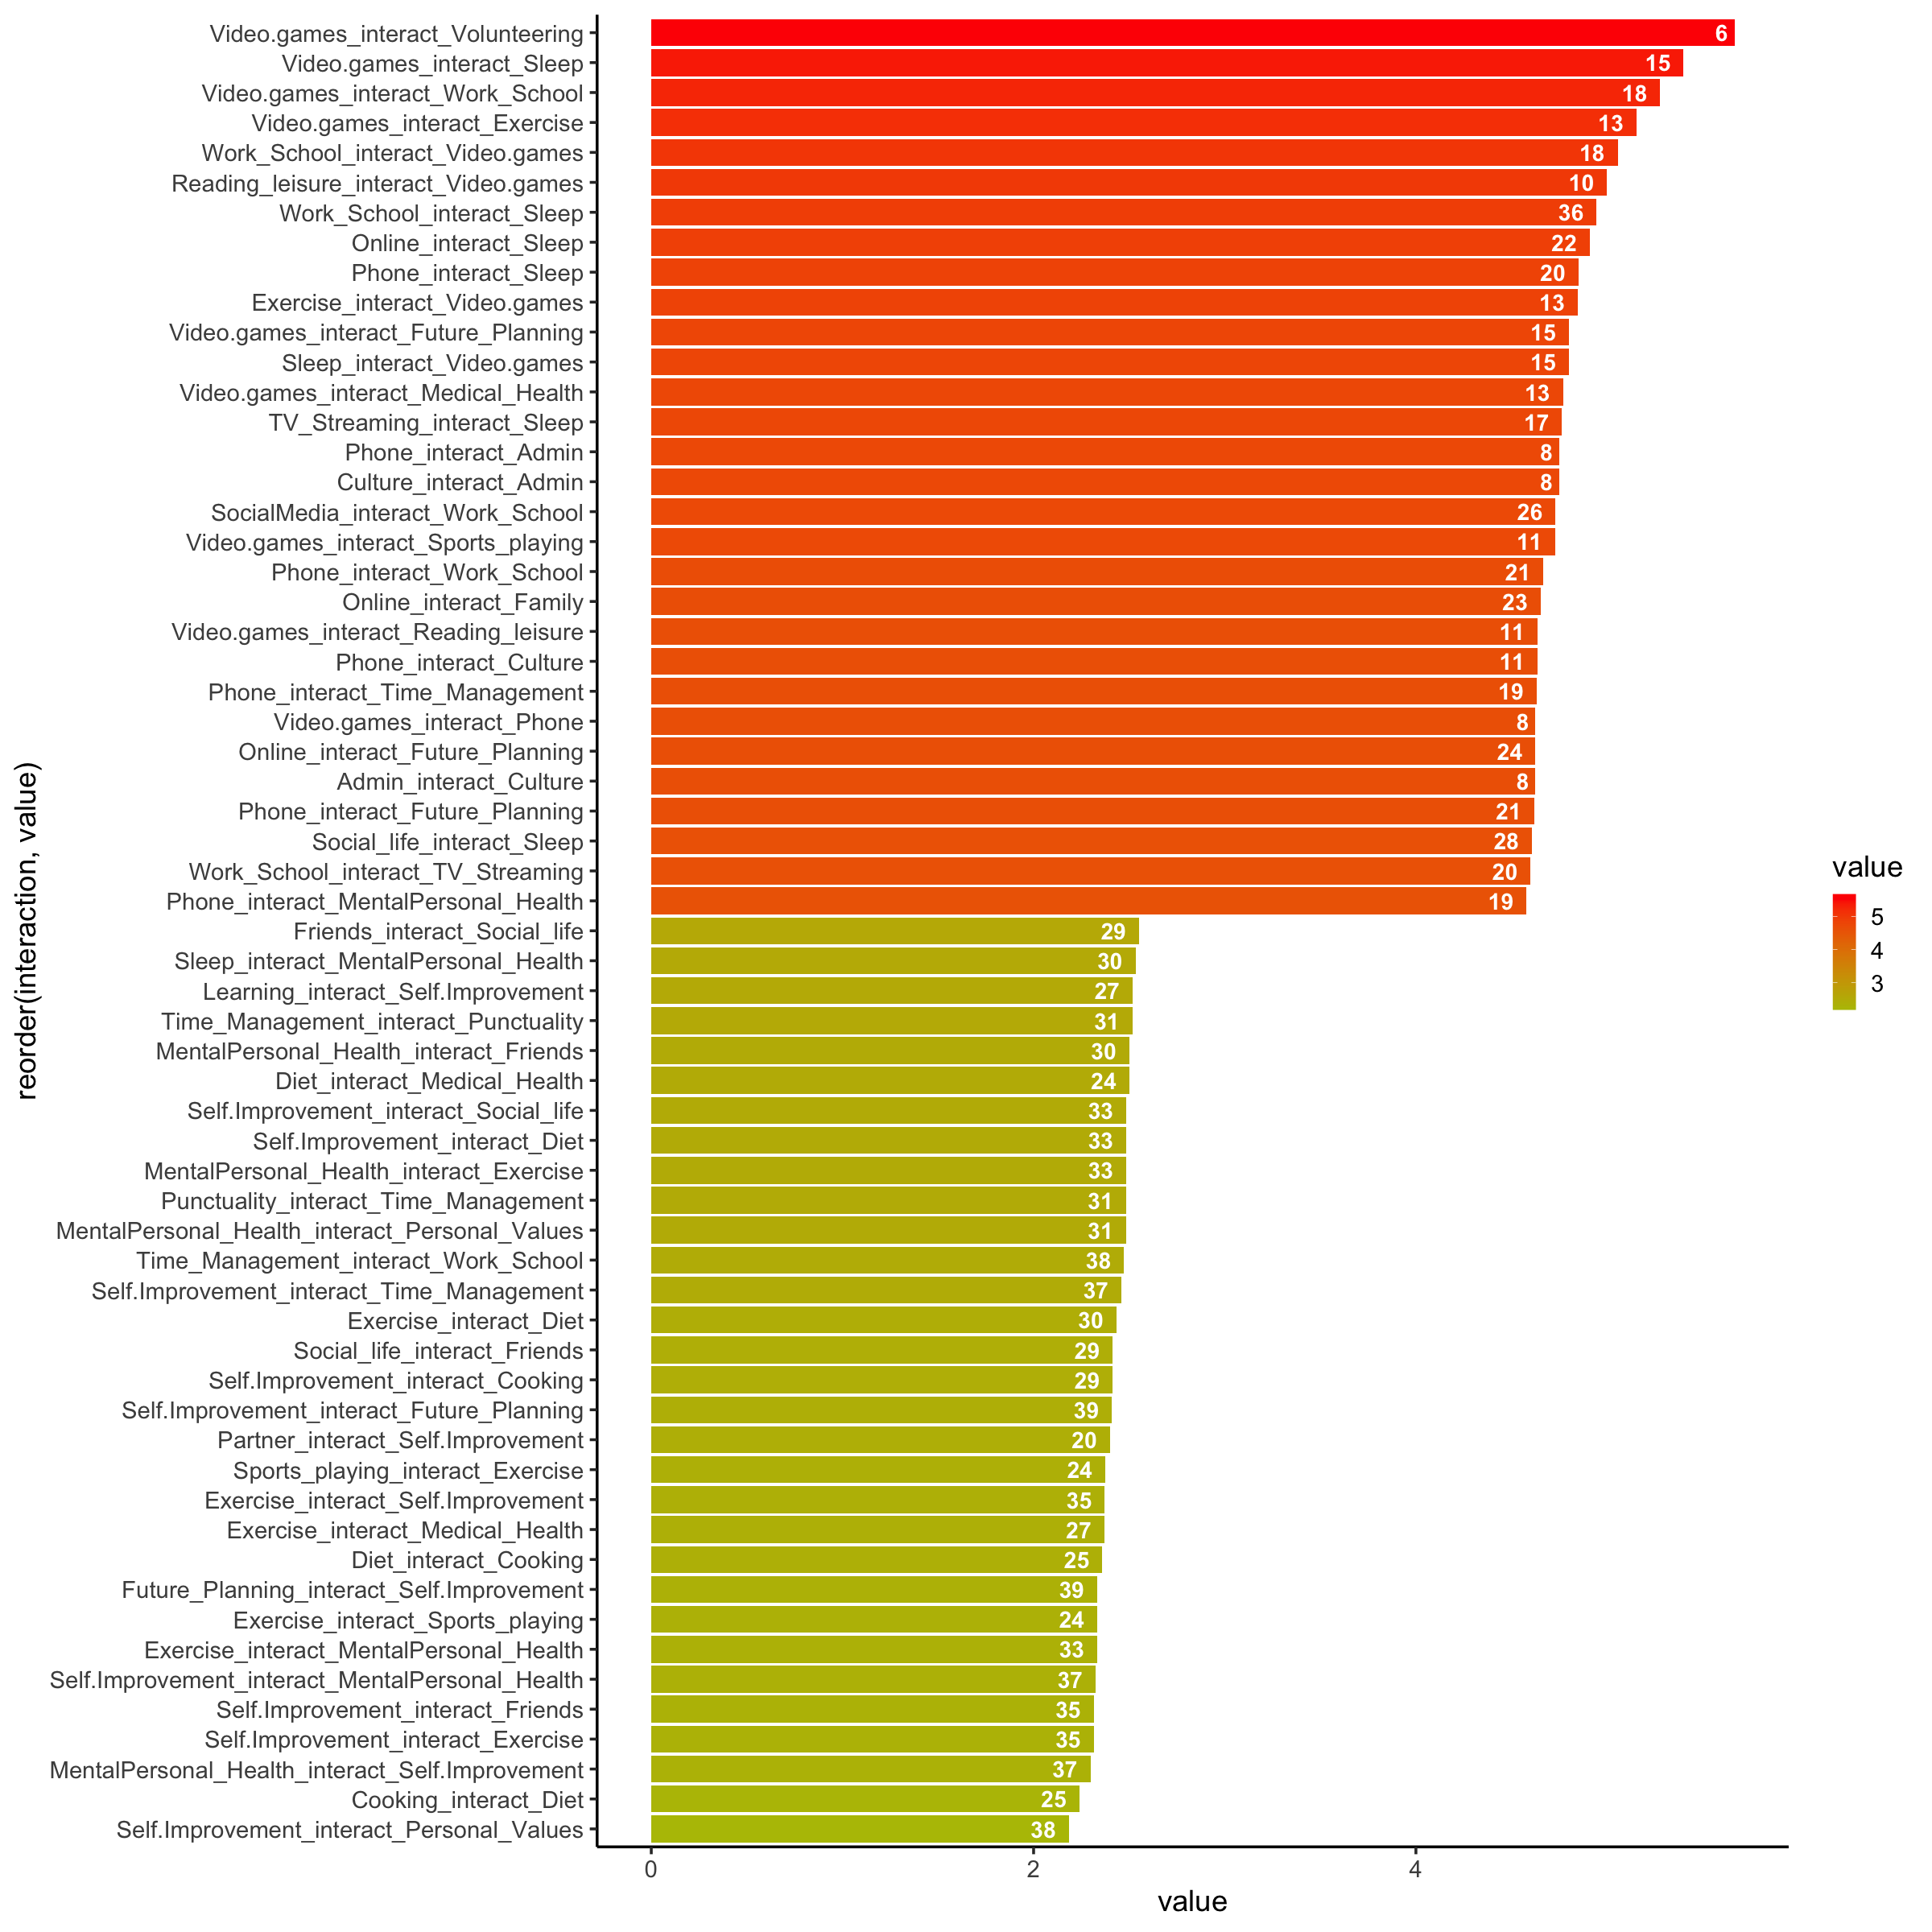

In [25]:
options(repr.plot.width = 20, repr.plot.height = 20)

ggplot(df_long[c(1:30, 1126:1156),], aes(x = reorder(interaction, value), y = value))+
  geom_bar(stat = 'identity', aes(fill = value)) +
    scale_fill_gradient2(mid='green', high='red') +
    geom_text(aes(label = n), hjust = 1.5, colour = 'white', fontface = "bold", size=6)+
    coord_flip() +
    theme_classic(base_size = 22)

# Within person goal conflict

In [26]:
avg_conflict = rowMeans(interaction_df, na.rm = T)

In [27]:
success = clean_sona4 %>%
    select(contains('domain_success')) %>%
    sapply(as.numeric) %>%
    as_tibble() %>%
    rowMeans(na.rm=T)
gap = 100 - success

In [28]:
clean_sona4$avg_domain_conflict = avg_conflict
clean_sona4$ib_gap = gap

In [29]:
cor(clean_sona4$avg_domain_conflict,clean_sona4$ib_gap)

[1] 0.1321415

In [30]:
summary(lm(ib_gap~avg_domain_conflict, data = clean_sona4))


Call:
lm(formula = ib_gap ~ avg_domain_conflict, data = clean_sona4)

Residuals:
    Min      1Q  Median      3Q     Max 
-26.714 -14.695   4.287  10.037  35.345 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)  
(Intercept)           29.519     16.430   1.797   0.0786 .
avg_domain_conflict    4.274      4.580   0.933   0.3553  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 16.28 on 49 degrees of freedom
Multiple R-squared:  0.01746,	Adjusted R-squared:  -0.00259 
F-statistic: 0.8708 on 1 and 49 DF,  p-value: 0.3553


In [31]:
within = data.frame(gap, avg_conflict)

`geom_smooth()` using formula 'y ~ x'



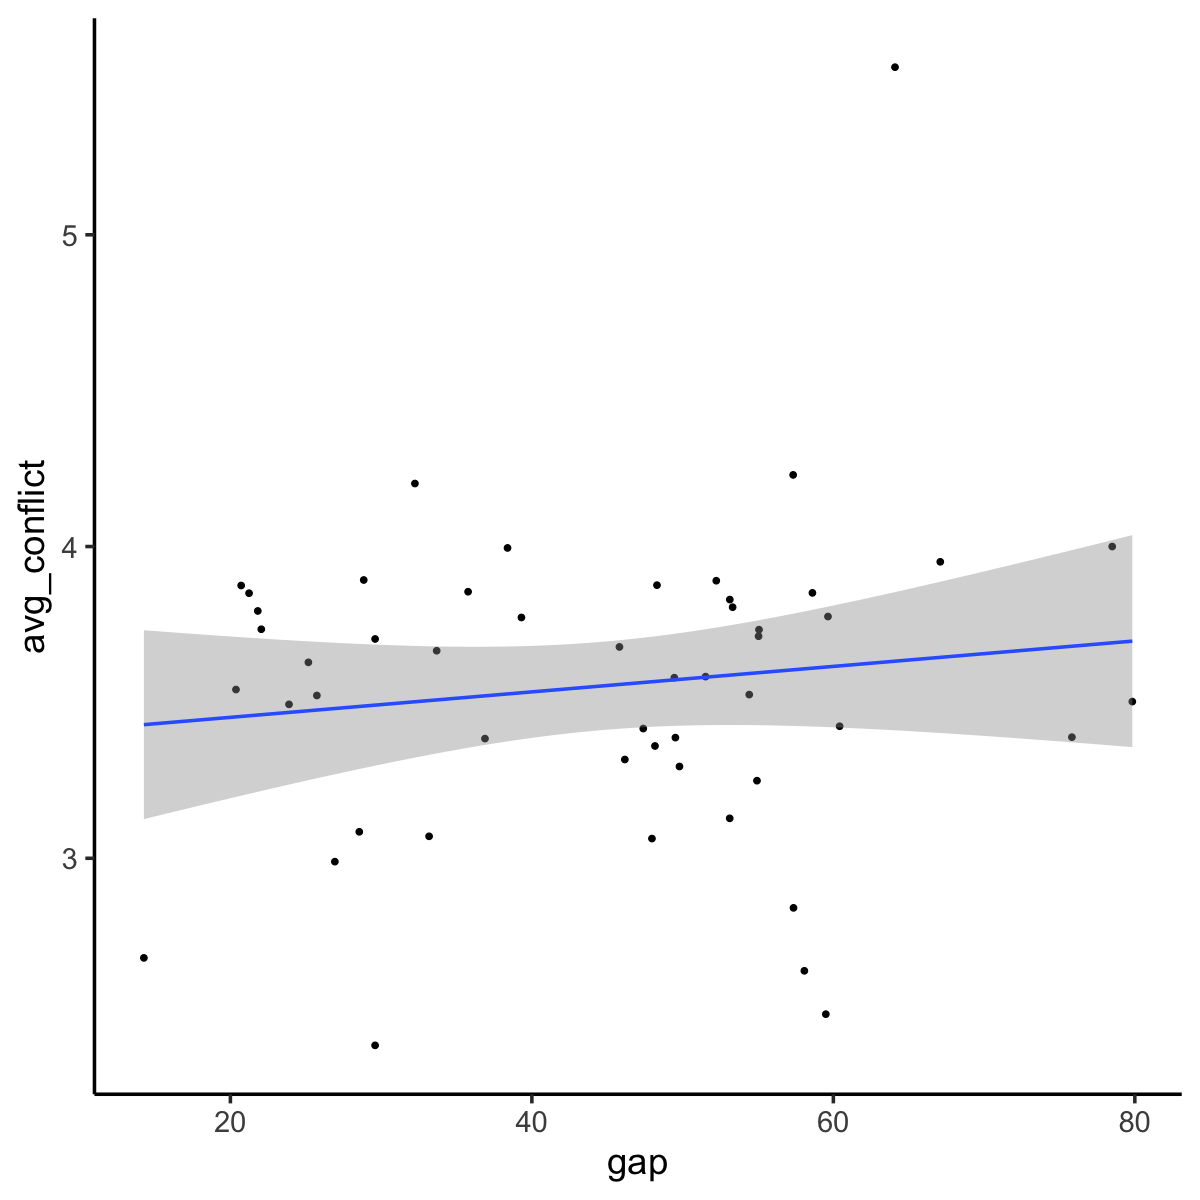

In [32]:
options(repr.plot.width = 10, repr.plot.height = 10)

ggplot(within, aes(x=gap, y=avg_conflict)) +
    geom_point() +
    stat_smooth(method = 'lm', se=TRUE) +
    theme_classic(base_size = 22)

### Check for all same answer

In [33]:
# do we have people with zero variance?

clean_sona4 %>%
    select(contains('goal_interact')) %>%
    sapply(as.numeric) %>%
    as_tibble() %>%
    apply(1, sd, na.rm=T) %>%
    sort()

[1] 0.00000000 0.06651857 0.45832691 0.49816711 0.58400360 0.60320192
 [7] 0.60582281 0.67535791 0.74116435 0.82634809 0.85202450 0.85725191
[13] 0.86213923 0.86522979 0.88732748 0.89465354 0.95431352 0.95553422
[19] 0.95836325 0.99001582 0.99117134 0.99456366 0.99861348 1.00000000
[25] 1.00287394 1.01820158 1.02162536 1.03846681 1.04295451 1.07369379
[31] 1.13174079 1.20140040 1.20356918 1.21458990 1.22676638 1.22687108
[37] 1.25941404 1.26076180 1.27767246 1.30853718 1.31089543 1.36513231
[43] 1.39600275 1.45363601 1.46377829 1.47890469 1.48923502 1.58211454
[49] 1.87861146 2.01296749 2.29128785

In [35]:
x = clean_sona4 %>% select(contains('goal_interact')) %>%
    sapply(as.numeric) %>%
    as_tibble() %>%
    apply(1, sd, na.rm=T)

idx_noVar = which(x==0)

In [36]:
# check what is going on...
not_all_na <- function(x) any(!is.na(x))

df[df$id=='22901',] %>% select(contains('interact')) %>% select(where(not_all_na))

10_goal_interact_10,10_goal_interact_18,10_goal_interact_21,10_goal_interact_25,18_goal_interact_10,18_goal_interact_18,18_goal_interact_21,18_goal_interact_25,21_goal_interact_10,21_goal_interact_18,21_goal_interact_21,21_goal_interact_25,25_goal_interact_10,25_goal_interact_18,25_goal_interact_21,25_goal_interact_25
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4


In [37]:
clean_sona4[-idx_noVar,]$ib_gap

[1] 49.79167 53.13043 52.23333 25.17391 14.26087 20.37037 59.64286 60.41667
 [9] 57.35714 49.52174 26.93103 51.52381 28.84615 21.23810 64.09091 53.31818
[17] 55.06667 54.93333 67.09375 54.42105 39.30769 23.88889 47.38889 75.82609
[25] 22.05000 55.03846 58.07692 57.33333 45.80952 33.18182 49.45000 29.60000
[33] 25.73684 59.50000 32.24138 58.61111 79.83333 36.88889 20.71429 47.96552
[41] 35.76923 48.16667 33.68421 28.55000 46.16667 38.38462 53.12500 21.81818
[49] 48.30000 29.60000

In [38]:
cor(clean_sona4[-idx_noVar,]$avg_domain_conflict, clean_sona4[-idx_noVar,]$ib_gap)

[1] 0.09969602

In [39]:
summary(lm(ib_gap~avg_domain_conflict, data = clean_sona4[-idx_noVar,]))


Call:
lm(formula = ib_gap ~ avg_domain_conflict, data = clean_sona4[-idx_noVar, 
    ])

Residuals:
    Min      1Q  Median      3Q     Max 
-27.086 -13.996   4.234  10.480  35.935 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)  
(Intercept)           33.027     16.003   2.064   0.0445 *
avg_domain_conflict    3.104      4.471   0.694   0.4909  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 15.76 on 48 degrees of freedom
Multiple R-squared:  0.009939,	Adjusted R-squared:  -0.01069 
F-statistic: 0.4819 on 1 and 48 DF,  p-value: 0.4909


In [41]:
clean_sona4 = clean_sona4[-idx_noVar,]

### Interaction Attention Check

In [42]:
# domain-domain interaction attention check
self_interact = ''

for(i in seq(34)){
    self_interact[i] = paste0(i, '_goal_interact_', i)
}

In [43]:
# all answers should be '4'
x = clean_sona4 %>%
    select(ends_with(self_interact)) %>%
    select(starts_with(self_interact)) %>%
    sapply(as.numeric) %>%
    as_tibble() %>%
    rowMeans(na.rm=T)
x

[1] 3.909091 4.045455 4.000000 1.217391 1.130435 2.814815 4.000000 3.545455
 [9] 4.000000 1.136364 2.103448 3.500000 3.769231 4.000000 3.000000 3.681818
[17] 3.785714 4.000000 4.000000 3.562500 4.000000 3.250000 3.375000 3.181818
[25] 4.000000 3.960000 3.920000 4.000000 4.000000 1.000000 4.000000 1.000000
[33] 3.789474 3.000000 4.000000 4.000000 2.833333 2.235294 4.000000 2.000000
[41] 4.000000 3.941176 4.000000 4.000000 4.000000 3.961538 3.437500 4.000000
[49] 4.000000 4.000000

In [44]:
# create index
good_subjects_idx = which(x==4)
# how many subjects left?
length(good_subjects_idx)

[1] 21

In [45]:
clean_sona4 = clean_sona4[good_subjects_idx,]

In [46]:
summary(lm(ib_gap~avg_domain_conflict, data= clean_sona4))


Call:
lm(formula = ib_gap ~ avg_domain_conflict, data = clean_sona4)

Residuals:
    Min      1Q  Median      3Q     Max 
-20.733 -12.396   2.934  11.483  25.890 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)
(Intercept)           53.843     37.147   1.449    0.164
avg_domain_conflict   -3.199      9.991  -0.320    0.752

Residual standard error: 15.04 on 19 degrees of freedom
Multiple R-squared:  0.005367,	Adjusted R-squared:  -0.04698 
F-statistic: 0.1025 on 1 and 19 DF,  p-value: 0.7523


# Save Data

In [49]:
interact_sona4 = interaction_df

In [51]:
write.csv(interact_sona4, "../../3_1_2_processed_data/interact_sona4.csv", row.names = FALSE)
write.csv(clean_sona4, "../../3_1_2_processed_data/clean_sona4.csv", row.names = FALSE)